In [1]:
import pandas as pd
import sqlite3 as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

cn = sq.connect('olist.db')
qry = "SELECT name FROM sqlite_master WHERE type='table';"
table = pd.read_sql_query(qry, cn)

def check_nan(df):
    nan = {'columns': [x for x in df.columns],
           'nan_count': [x for x in df.isna().sum()],
           'nan_%': [x for x in df.isna().sum() / len(df) * 100]
          }
    nan_test = pd.DataFrame(nan)
    result = nan_test[nan_test['nan_count'] != 0].sort_values(by='nan_count', ascending=False).reset_index()
    result = result.iloc[:, 1:]
    pd.set_option('display.max_columns', len(df.columns))
    pd.set_option('display.max_rows', len(df))
    return result

def check_non_blank(df, base_cols, count_cols, show='all'):
    category = list(df[base_cols])
    values = list(df[count_cols].isna())
    result = {base_cols: category,
              'blank': list(map(lambda x: 1 if x else 0, values)),
              'not_blank': list(map(lambda x: 0 if x else 1, values))
             }
    df_result = pd.DataFrame(result)
    
    pd.set_option('display.max_columns', len(df.columns))
    pd.set_option('display.max_rows', len(df))
    
    if show == 'all':
        return df_result.groupby(base_cols).sum()
    elif show == 'blank':
        return df_result[df_result['blank'] > 0].groupby(base_cols).sum()
    elif show == 'not_blank':
        return df_result[df_result['not_blank'] > 0].groupby(base_cols).sum()
    else:
        raise ValueError("Invalid value for 'show' parameter. Use 'all', 'blank', or 'not-blank'.")

In [2]:
# declare every single table to variables
customer = pd.read_sql_query("SELECT * FROM olist_order_customer_dataset", cn)
order = pd.read_sql_query("SELECT * FROM olist_order_dataset", cn)
order_list = pd.read_sql_query("SELECT * FROM olist_order_items_dataset", cn)
review = pd.read_sql_query("SELECT * FROM olist_order_reviews_dataset", cn)
payment = pd.read_sql_query("SELECT * FROM olist_order_payments_dataset", cn)
product = pd.read_sql_query("SELECT * FROM olist_products_dataset", cn)
seller = pd.read_sql_query("SELECT * FROM olist_sellers_dataset", cn)
location = pd.read_sql_query("SELECT * FROM olist_geolocation_dataset", cn)

# helper table table for state name
state = pd.read_csv('C:/Users/NublzPC/OneDrive/Pacmann/SQL Data Wrangling/project/brazil_state.csv')
translate = pd.read_sql_query("SELECT * FROM product_category_name_translation", cn)

# PERSONAL NOTE

In [3]:
# merge necesary df to 1 single df
main_df = order_list.merge(order, on='order_id', how='outer')
main_df = main_df.merge(review[['order_id', 'review_score']],
                        on='order_id', how='left')
main_df = main_df.merge(product[['product_id', 'product_category_name', 'product_photos_qty']],
                       on='product_id', how='left')
main_df = main_df.merge(translate[['product_category_name', 'product_category_name_english']],
                       on='product_category_name', how='left')
main_df = main_df.merge(customer[['customer_id', 'customer_state']],
                       on='customer_id', how='left')
main_df = main_df.merge(seller[['seller_id', 'seller_state']],
                       on='seller_id', how='left')
main_df = main_df.merge(state[['geolocation_state', 'name']],
                       left_on='customer_state',
                       right_on='geolocation_state',
                       how='left')
main_df = main_df.merge(state[['geolocation_state', 'name']],
                       left_on='seller_state',
                       right_on='geolocation_state',
                       how='left')

In [4]:
# drop several column
main_df.drop(columns=['customer_state', 'seller_state', 'geolocation_state_x', 'geolocation_state_y'], 
        inplace=True)

# rename ambiguous column
main_df = main_df.rename(columns={'name_x': 'customer_state',
                                  'name_y': 'seller_state'})

# gerenal check
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_x                        113314 non-null  float64
 1   order_id                       114092 non-null  object 
 2   order_item_id                  113314 non-null  float64
 3   product_id                     113314 non-null  object 
 4   seller_id                      113314 non-null  object 
 5   shipping_limit_date            113314 non-null  object 
 6   price                          113314 non-null  float64
 7   freight_value                  113314 non-null  float64
 8   index_y                        114092 non-null  int64  
 9   customer_id                    114092 non-null  object 
 10  order_status                   114092 non-null  object 
 11  order_purchase_timestamp       114092 non-null  object 
 12  order_approved_at             

In [5]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_x                        113314 non-null  float64
 1   order_id                       114092 non-null  object 
 2   order_item_id                  113314 non-null  float64
 3   product_id                     113314 non-null  object 
 4   seller_id                      113314 non-null  object 
 5   shipping_limit_date            113314 non-null  object 
 6   price                          113314 non-null  float64
 7   freight_value                  113314 non-null  float64
 8   index_y                        114092 non-null  int64  
 9   customer_id                    114092 non-null  object 
 10  order_status                   114092 non-null  object 
 11  order_purchase_timestamp       114092 non-null  object 
 12  order_approved_at             

In [6]:
# membuat copy dari dataframe untuk backup
copied_df = main_df.copy()

# mengubah view agar bisa menampilkan semua nama kolom
pd.set_option('display.max_columns', len(copied_df.columns))

# ubah urutan kolom untuk mempermudah pengecekan
copied_df = copied_df[['order_id',
'order_item_id',
'product_id',
'seller_id',
'seller_state',         
'customer_id',
'customer_state',
'order_status',
'price',
'freight_value',
'order_purchase_timestamp',
'order_approved_at',
'shipping_limit_date',
'order_delivered_carrier_date',
'order_estimated_delivery_date',
'order_delivered_customer_date',
'review_score',
'product_category_name',
'product_photos_qty',
'product_category_name_english']]

# 1. Parsing Date

In [7]:
copied_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       114092 non-null  object 
 1   order_item_id                  113314 non-null  float64
 2   product_id                     113314 non-null  object 
 3   seller_id                      113314 non-null  object 
 4   seller_state                   113314 non-null  object 
 5   customer_id                    114092 non-null  object 
 6   customer_state                 114092 non-null  object 
 7   order_status                   114092 non-null  object 
 8   price                          113314 non-null  float64
 9   freight_value                  113314 non-null  float64
 10  order_purchase_timestamp       114092 non-null  object 
 11  order_approved_at              113930 non-null  object 
 12  shipping_limit_date           

In [8]:
# change date stored as object to datetime format
copied_df.order_purchase_timestamp = pd.to_datetime(copied_df.order_purchase_timestamp)
copied_df.order_approved_at = pd.to_datetime(copied_df.order_approved_at)
copied_df.order_delivered_carrier_date = pd.to_datetime(copied_df.order_delivered_carrier_date)
copied_df.order_delivered_customer_date = pd.to_datetime(copied_df.order_delivered_customer_date)
copied_df.order_estimated_delivery_date = pd.to_datetime(copied_df.order_estimated_delivery_date)
copied_df.shipping_limit_date = pd.to_datetime(main_df.shipping_limit_date)

# 2. Cleaning Data
## 2.1 Check missing values

In [9]:
# check
check_nan(copied_df)

,columns,nan_count,nan_%
0,order_delivered_customer_date,3253,2.851208
1,product_category_name_english,2414,2.115836
2,product_category_name,2390,2.094801
3,product_photos_qty,2390,2.094801
4,order_delivered_carrier_date,1980,1.735442
5,review_score,961,0.842303
6,order_item_id,778,0.681906
7,product_id,778,0.681906
8,seller_id,778,0.681906
9,seller_state,778,0.681906


#### 2.1.1 Missing values di kolom `product_id`

In [10]:
# drop row that contain na in column product_id because this is a key column
copied_df = copied_df.dropna(subset=['product_id'])
check_nan(copied_df)

,columns,nan_count,nan_%
0,order_delivered_customer_date,2475,2.184196
1,product_category_name_english,1636,1.443776
2,product_category_name,1612,1.422596
3,product_photos_qty,1612,1.422596
4,order_delivered_carrier_date,1203,1.061652
5,review_score,942,0.831318
6,order_approved_at,15,0.013238


#### 2.1.2 Missing values di kolom `order_delivered_customer_date`

In [11]:
# cek jumlah null di setiap order_status
check_non_blank(copied_df,
                'order_status',
                'order_delivered_customer_date')

,blank,not_blank
order_status,,
approved,3,0
canceled,539,7
delivered,8,110832
invoiced,364,0
processing,358,0
shipped,1196,0
unavailable,7,0


apabila _order_status_ sudah delivered tetapi _order_delivered_customer_date_ masih null, maka akan diisi dengan value dari kolom _order_estimated_delivery_date_ dan dapat diasumsikan pengiriman tersebut tepat waktu.

In [12]:
# fill na menggunakan np.where()
copied_df['order_delivered_customer_date'] = np.where(
    (copied_df['order_status'] == 'delivered') & (copied_df['order_delivered_customer_date'].isna()),
    copied_df['order_estimated_delivery_date'],
    copied_df['order_delivered_customer_date'])

check_nan(copied_df)

,columns,nan_count,nan_%
0,order_delivered_customer_date,2467,2.177136
1,product_category_name_english,1636,1.443776
2,product_category_name,1612,1.422596
3,product_photos_qty,1612,1.422596
4,order_delivered_carrier_date,1203,1.061652
5,review_score,942,0.831318
6,order_approved_at,15,0.013238


#### 2.1.3 Missing values di kolom `order_approved_at`

In [13]:
# check order_status untuk setiap missing value di kolom _order_approved_at_ 
check_non_blank(copied_df, 'order_status', 'order_approved_at')

,blank,not_blank
order_status,,
approved,0,3
canceled,0,546
delivered,15,110825
invoiced,0,364
processing,0,358
shipped,0,1196
unavailable,0,7


In [14]:
# fill na menggunakan np.where()
copied_df['order_approved_at'] = np.where(copied_df['order_approved_at'].isna(),
                                        copied_df['order_purchase_timestamp'],
                                        copied_df['order_approved_at'])

check_nan(copied_df)

,columns,nan_count,nan_%
0,order_delivered_customer_date,2467,2.177136
1,product_category_name_english,1636,1.443776
2,product_category_name,1612,1.422596
3,product_photos_qty,1612,1.422596
4,order_delivered_carrier_date,1203,1.061652
5,review_score,942,0.831318


#### 2.1.4 Missing values di kolom `product_category_name_english`
value di kolom _product_category_name_english_ null dikarenakan value pada kolom _product_category_name_ juga null, atau bisa juga dikarenakan _product_category_name_ tidak tercatat di tabel _product_. Untuk mengatasi masalah ini dilakukan inputing sebagai berikut
 - kategori pc_gamer akan diinput ke `product_category_name_english` dikarenakan itu sudah berbahasa Inggris
 - untuk kategori lainnya akan diubah menjadi `others`

In [15]:
# check setiap product_category_name yang value dari product_category_name_english adalah Na
check_non_blank(copied_df, 'product_category_name', 'product_category_name_english', show='blank')

,blank,not_blank
product_category_name,,
pc_gamer,9,0
portateis_cozinha_e_preparadores_de_alimentos,15,0


In [16]:
# mengubah product_category_name_english yg kosong menjadi 'pc_gamer'
copied_df['product_category_name_english'] = np.where(
    (copied_df['product_category_name'] == 'pc_gamer') & (copied_df['product_category_name_english'].isna()),
    copied_df['product_category_name'],
    copied_df['product_category_name_english'])

# filling yg masih kosong dengan 'others'
copied_df['product_category_name_english'].fillna('others', inplace=True)

check_nan(copied_df)

,columns,nan_count,nan_%
0,order_delivered_customer_date,2467,2.177136
1,product_category_name,1612,1.422596
2,product_photos_qty,1612,1.422596
3,order_delivered_carrier_date,1203,1.061652
4,review_score,942,0.831318


#### 2.1.5 Missing values di kolom `product_photos_qty`

In [17]:
# cek deskripsi adri kolom product_photos_qty untuk menentukan akan diisi dengan apa kolom yg kosong
copied_df['product_photos_qty'].describe()

count    111702.000000
mean          2.206908
std           1.719500
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          20.000000
Name: product_photos_qty, dtype: float64

In [18]:
median_photos = copied_df['product_photos_qty'].median()
copied_df['product_photos_qty'].fillna(median_photos, inplace=True)
check_nan(copied_df)

,columns,nan_count,nan_%
0,order_delivered_customer_date,2467,2.177136
1,product_category_name,1612,1.422596
2,order_delivered_carrier_date,1203,1.061652
3,review_score,942,0.831318


#### 2.1.6 Missing values di kolom `order_delivered_carrier_date`

In [19]:
# cek jumlah kolom blank dan tidak blank di setiap order_status
check_non_blank(main_df, 'order_status', 'order_delivered_carrier_date')

,blank,not_blank
order_status,,
approved,3,0
canceled,634,77
created,5,0
delivered,2,110838
invoiced,366,0
processing,358,0
shipped,0,1197
unavailable,612,0


Dari data di atas dapat dilihat bahwa missing value pada status **delivered** adalah sebuah kesalahan, seharusnya apabila status dudah delivered, kolom `order_delivered_carrier_date` terisi semua dengan tanggal. Maka akan dilakukan inputasi di kolom tsb dengan value dari kolom `shipping_limit_date`

Dan untuk status **canceled** akan dibiarkan, dikarenakan hal tersebut terjadi mungkin karena ketika paket sudah diserahkan ke kurir tetapi pesanan terlanjur dicancel oleh buyer

Dan untuk value di kolom `order_delivered_carrier_date` dengan status **canceled** akan dihapus semua, karena ini diasumsikan terjadi kesalahan input

In [20]:
# fill na menggunakan di kolom order_delivered_carrier_date order_status=delivered
main_df['order_delivered_carrier_date'] = np.where(
    (main_df['order_status'] == 'delivered') & (main_df['order_delivered_carrier_date'].isna()),
    main_df['shipping_limit_date'],
    main_df['order_delivered_carrier_date'])

# fill na menggunakan di kolom order_delivered_carrier_date order_status=canceled
main_df['order_delivered_carrier_date'] = np.where(
    main_df['order_status'] == 'canceled',
    pd.NaT,
    main_df['order_delivered_carrier_date'])

check_non_blank(main_df, 'order_status', 'order_delivered_carrier_date')

,blank,not_blank
order_status,,
approved,3,0
canceled,711,0
created,5,0
delivered,0,110840
invoiced,366,0
processing,358,0
shipped,0,1197
unavailable,612,0


## 2.2 Check duplicates

In [21]:
[copied_df.shape, copied_df.duplicated().any()]

[(113314, 20), True]

In [22]:
copied_df = copied_df.drop_duplicates(keep='first')
[copied_df.shape, copied_df.duplicated().any()]

[(112915, 20), False]

## Date Manipulation

In [23]:
drop_cols = ['product_category_name', 'order_item_id']
copied_df.drop(columns=drop_cols, inplace=True)

In [24]:
# create new column for day name and date
copied_df['purchase_day'] = copied_df.order_purchase_timestamp.dt.day_name()
copied_df['purchase_date'] = copied_df.order_purchase_timestamp.dt.day
copied_df['purchase_month'] = copied_df.order_purchase_timestamp.dt.month
copied_df['purchase_year'] = copied_df.order_purchase_timestamp.dt.year
copied_df['delivery_duration'] = (copied_df.order_delivered_customer_date -
                                  copied_df.order_delivered_carrier_date).dt.days
copied_df['process_duration'] = np.ceil((copied_df.order_delivered_carrier_date -
                                 copied_df.order_approved_at).dt.total_seconds() / 3600 / 24)

In [25]:
copied_df.head()

,order_id,product_id,seller_id,seller_state,customer_id,customer_state,order_status,price,freight_value,order_purchase_timestamp,order_approved_at,...,order_estimated_delivery_date,order_delivered_customer_date,review_score,product_photos_qty,product_category_name_english,purchase_day,purchase_date,purchase_month,purchase_year,delivery_duration,process_duration
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,Sao Paulo,3ce436f183e68e07877b285a838db11a,Rio de Janeiro,delivered,58.90,13.29,2017-09-13 08:59:02,2017-09-13 09:45:35,...,2017-09-29,2017-09-20 23:43:48,5.0,4.0,cool_stuff,Wednesday,13,9,2017,1.0,7.0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,Sao Paulo,f6dd3ec061db4e3987629fe6b26e5cce,Sao Paulo,delivered,239.90,19.93,2017-04-26 10:53:06,2017-04-26 11:05:13,...,2017-05-15,2017-05-12 16:04:24,4.0,2.0,pet_shop,Wednesday,26,4,2017,8.0,9.0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,Minas Gerais,6489ae5e4333f3693df5ad4372dab6d3,Minas Gerais,delivered,199.00,17.87,2018-01-14 14:33:31,2018-01-14 14:48:30,...,2018-02-05,2018-01-22 13:19:16,5.0,2.0,furniture_decor,Sunday,14,1,2018,6.0,2.0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,Sao Paulo,d4eb9395c8c0431ee92fce09860c5a06,Sao Paulo,delivered,12.99,12.79,2018-08-08 10:00:35,2018-08-08 10:10:18,...,2018-08-20,2018-08-14 13:32:39,4.0,1.0,perfumery,Wednesday,8,8,2018,4.0,3.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,Parana,58dbd0b2d70206bf40e62cd34e84d795,Sao Paulo,delivered,199.90,18.14,2017-02-04 13:57:51,2017-02-04 14:10:13,...,2017-03-17,2017-03-01 16:42:31,5.0,1.0,garden_tools,Saturday,4,2,2017,13.0,12.0


# Handling Outlier

### Check Outlier from Column `delivery_duration_day`

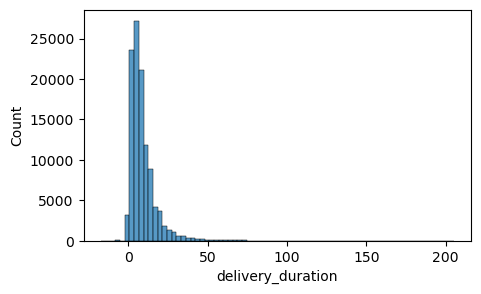

In [26]:
# membuat histogram dari kolom price untuk mempermudah melihat outlier
fig, ax = plt.subplots(figsize = (5, 3))
sns.histplot(data = copied_df,
             x = 'delivery_duration',
             bins = 75,
             ax = ax)
plt.show()

In [27]:
# deskripsi statistik dari kolom prie
copied_df.delivery_duration.describe()

count    110454.000000
mean          8.736678
std           8.611703
min         -17.000000
25%           4.000000
50%           7.000000
75%          11.000000
max         205.000000
Name: delivery_duration, dtype: float64

dapat dilihat terdapat data yg lebih kecil dari 0 di mana data tersebut tidak valid, dan terdapat data yg sangat besar

In [28]:
# mencari Q1 & Q3
q1_duration = copied_df.delivery_duration.quantile(.25)
q3_duration = copied_df.delivery_duration.quantile(.75)

# mencari IQR & Maximum
iqr_duration = q3_duration - q1_duration
max_duration = np.ceil(q3_duration + 1.5 * iqr_duration) # dibulatkan ke atas
 
print(f'q1_duration: {q1_duration}')
print(f'q3_duration: {q3_duration}')
print(f'iqr_duration: {iqr_duration}')
print(f'max_duration: {max_duration}')

q1_duration: 4.0
q3_duration: 11.0
iqr_duration: 7.0
max_duration: 22.0


In [29]:
# cek ada berapa banyak data delivery_duration_day < 0
x, y = copied_df[copied_df.delivery_duration < 0].shape
print(f'Jumlah baris yang di bawah 0: {x}')

Jumlah baris yang di bawah 0: 50


karena datanya sangat sedikit (50 baris), maka akan dihapus

In [30]:
# drop data yg delivery_duration_day < 0
filtered_data = copied_df[copied_df.delivery_duration >= 0]
filtered_data.delivery_duration.describe()

count    110404.000000
mean          8.742274
std           8.609302
min           0.000000
25%           4.000000
50%           7.000000
75%          11.000000
max         205.000000
Name: delivery_duration, dtype: float64

In [31]:
rows, cols = filtered_data[filtered_data.delivery_duration > max_duration].shape
total_rows = len(filtered_data)
f'{(rows/total_rows * 100):.2f}%'

'5.48%'

pada kolom `delivery_duration_day` terdapat lebih dari 5% data yg masuk kategori outlier, karena cukup banyak maka kolom tersebut akan dibuat sebagai kategorikal seperti berikut:
  - 1 day
  - 2-3 days
  - 4-5 days
  - 6-7 days
  - 8-10 days
  - 10-12 days
  - 12 days ++

In [32]:
categorized_day = [
    (filtered_data.delivery_duration > 12),
    (filtered_data.delivery_duration >= 10),
    (filtered_data.delivery_duration >= 8),
    (filtered_data.delivery_duration >= 6),
    (filtered_data.delivery_duration >= 4),
    (filtered_data.delivery_duration >= 2),
    (filtered_data.delivery_duration >= 0)
]

category = ['>12 days', '10-12 days', '8-10 days', '6-7 days', '4-5 days', '2-3 days', '0-1 day']

filtered_data['delivery_duration'] = np.select(categorized_day, category)

C:\Users\NublzPC\AppData\Local\Temp\ipykernel_4996\3592286708.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['delivery_duration'] = np.select(categorized_day, category)


## Check Outlier from Column `process_duration_day`

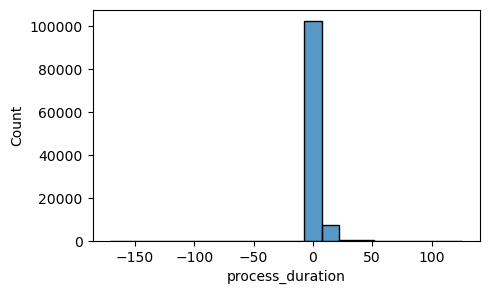

In [33]:
# membuat histogram dari kolom price untuk mempermudah melihat outlier
fig, ax = plt.subplots(figsize = (5, 3))
sns.histplot(data = filtered_data,
             x = 'process_duration',
             bins = 20,
             ax = ax)
plt.show()

In [34]:
filtered_data.process_duration.describe()

count    110404.000000
mean          3.341681
std           3.586760
min        -171.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         126.000000
Name: process_duration, dtype: float64

In [35]:
rows, cols = filtered_data[filtered_data.process_duration < 0].shape
total_rows = len(filtered_data.process_duration)
f'{(rows/total_rows * 100):.2f}%'

'0.48%'

karena datanya sangat sedikit (<1%), maka akan dihapus

In [36]:
# drop data yg delivery_duration_day < 0
filtered_data = filtered_data[filtered_data.process_duration >= 0]
filtered_data.process_duration.describe()

count    109879.000000
mean          3.368251
std           3.536323
min          -0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         126.000000
Name: process_duration, dtype: float64

In [37]:
filtered_data.process_duration = filtered_data.process_duration.replace("-", "")

pada kolom `delivery_duration_day` terdapat lebih dari 5% data yg masuk kategori outlier, karena cukup banyak maka kolom tersebut akan dibuat sebagai kategorikal seperti berikut:
  - < 1 day
  - 1-2 days
  - 3-4 days
  - 5-7 days
  - 7 days ++

In [38]:
categorized_day = [
    (filtered_data.process_duration > 7),
    (filtered_data.process_duration >= 5),
    (filtered_data.process_duration >= 3),
    (filtered_data.process_duration >= 1),
    (filtered_data.process_duration == 0)
]

category = ['> 7 days', '5-7 days', '3-4 days', '1-2 days', '< 1 day']

filtered_data['process_duration'] = np.select(categorized_day, category)

## Objective
#### 1. hari apa kebanyakan transaksi terjadi?

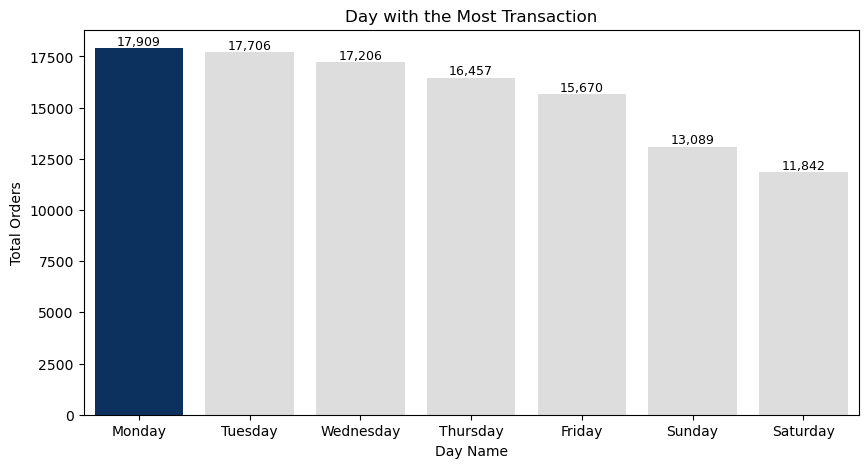

In [39]:
# hari dengan jumlah transaksi terbanyak
trx_most_day = filtered_data.groupby('purchase_day').count()['order_id'].sort_values(ascending=False).reset_index()

# setting data yg paling tinggi akan memiliki warna berbeda
highest = trx_most_day.order_id.max()
colors = ['#002F6C' if val == highest else '#DDDDDD' for val in trx_most_day.order_id]

# visualisasi
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data = trx_most_day,
            x = 'purchase_day',
            y = 'order_id',
            ax = ax,
            palette = colors)

# memberikan label ke setiap bar
for cont1 in ax.containers:
    labels = [f'{total:,.0f}' for total in cont1.datavalues]
    ax.bar_label(cont1, labels, fontsize=9)

# rename x, y axis and title
ax.set_title('Day with the Most Transaction')
ax.set_xlabel('Day Name')
ax.set_ylabel('Total Orders')

# menampilkan bar plot
plt.show()

#### 1.1 Tanggal dengan jumlah transaksi terbanyak

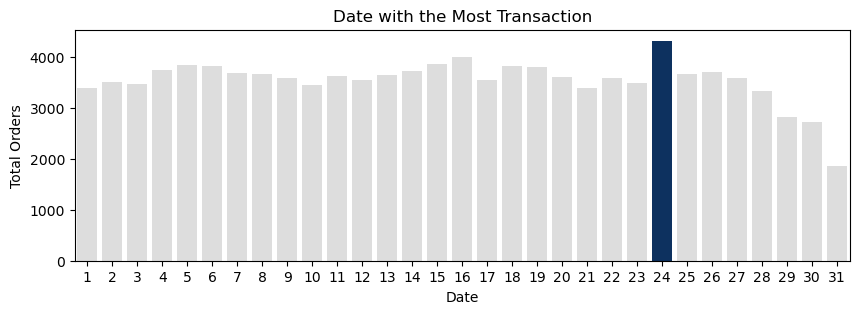

In [40]:
# grouping data
trx_most_date = filtered_data.groupby('purchase_date').count()['order_id'].reset_index()

# setting data yg paling tinggi akan memiliki warna berbeda
highest = trx_most_date.order_id.max()
colors = ['#002F6C' if val == highest else '#DDDDDD' for val in trx_most_date.order_id]

fig, ax = plt.subplots(figsize = (10, 3))
sns.barplot(data = trx_most_date,
            x = 'purchase_date',
            y = 'order_id',
            ax = ax,
            palette = colors)

plt.xlabel('Date')
plt.ylabel('Total Orders')
plt.title('Date with the Most Transaction')

plt.show()

#### 1.1 Bulan dengan transaksi terbanyak yang hanya tanggal 24 saja

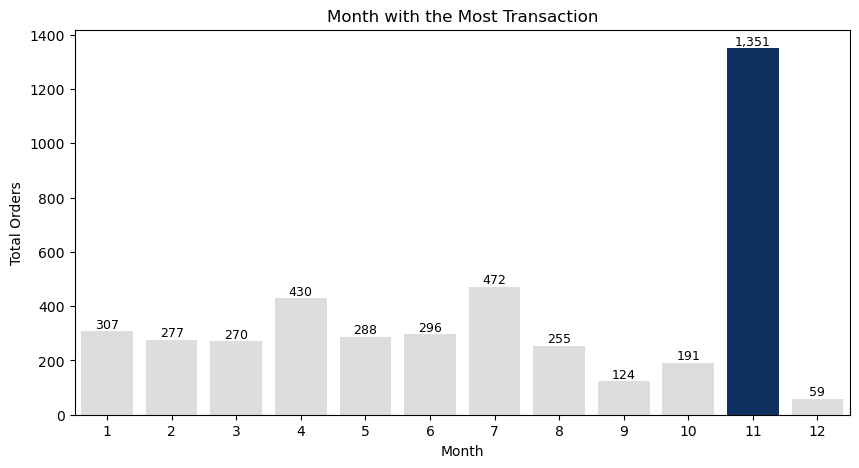

In [41]:
# filtering & grouping data
only_24 = filtered_data[filtered_data.purchase_date == 24]
trx_most_mos = only_24.groupby('purchase_month').count()['order_id'].reset_index()

# setting data yg paling tinggi akan memiliki warna berbeda
highest = trx_most_mos.order_id.max()
colors = ['#002F6C' if val == highest else '#DDDDDD' for val in trx_most_mos.order_id]

# visualisasi
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data = trx_most_mos,
            x = 'purchase_month',
            y = 'order_id',
            ax = ax,
            palette = colors)

# memberikan label ke setiap bar
for cont in ax.containers:
    labels = [f'{total:,.0f}' for total in cont.datavalues]
    ax.bar_label(cont, labels, fontsize=9)

# rename x, y axis and title
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.title('Month with the Most Transaction')

# menampilkan bar plot
plt.show()

#### 1.2 Tahun dengan transaksi terbanyak dengan kondisi tanggal 24, bulan 11

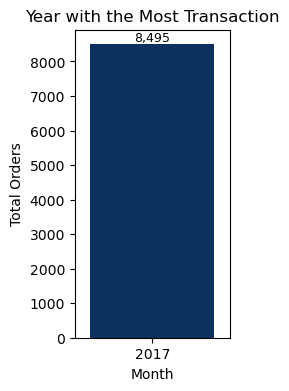

In [42]:
# filtering & grouping data
only_11 = filtered_data[filtered_data.purchase_month == 11]
trx_most_yr = only_11.groupby('purchase_year').count()['order_id'].reset_index()

# setting data yg paling tinggi akan memiliki warna berbeda
highest = trx_most_yr.order_id.max()
colors = ['#002F6C' if val == highest else '#DDDDDD' for val in trx_most_yr.order_id]

# visualisasi
fig, ax = plt.subplots(figsize = (2, 4))
sns.barplot(data = trx_most_yr,
            x = 'purchase_year',
            y = 'order_id',
            ax = ax,
            palette = colors)

# memberikan label ke setiap bar
for cont in ax.containers:
    labels = [f'{total:,.0f}' for total in cont.datavalues]
    ax.bar_label(cont, labels, fontsize=9)

# rename x, y axis and title
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.title('Year with the Most Transaction')

# menampilkan bar plot
plt.show()

#### 2. Persebaran seller

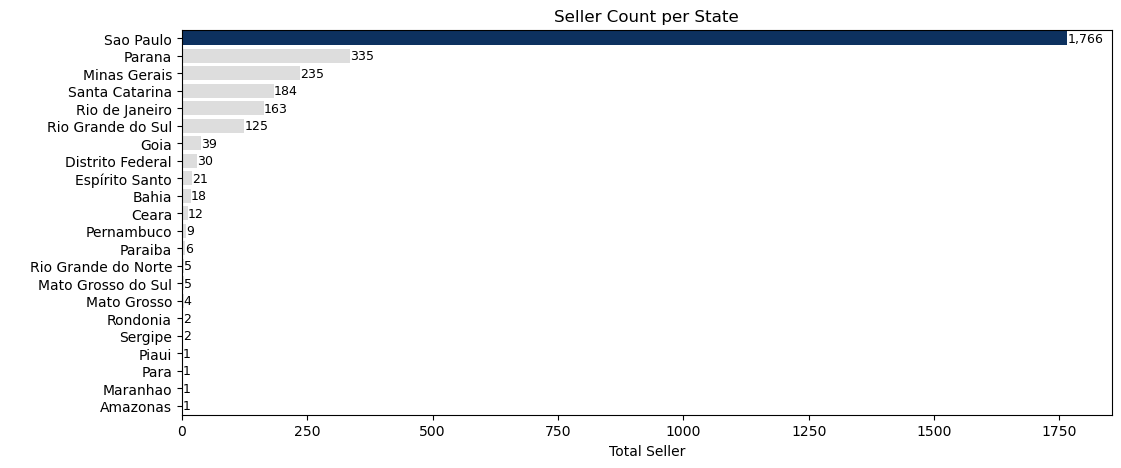

In [43]:
# filtering & grouping data frame
sellers_per_state = filtered_data.groupby('seller_state')['seller_id'].nunique().sort_values(ascending=False).reset_index()

# setting data yg paling tinggi akan memiliki warna berbeda
highest = sellers_per_state.seller_id.max()
colors = ['#002F6C' if val == highest else '#DDDDDD' for val in sellers_per_state.seller_id]

# visualisasi
fig, ax = plt.subplots(figsize = (12, 5))
sns.barplot(data = sellers_per_state,
            x = 'seller_id',
            y = 'seller_state',
            ax = ax,
            palette = colors)

# memberikan label ke setiap bar
for cont in ax.containers:
    labels = [f'{total:,.0f}' for total in cont.datavalues]
    ax.bar_label(cont, labels, fontsize=9)

# rename x, y axis and title
ax.set_title('Seller Count per State')
ax.set_ylabel(' ')
ax.set_xlabel('Total Seller')

# menampilkan bar plot
plt.show()

#### 3. Jumlah seller dengan rataan review score terburuk untuk state Sao Paulo

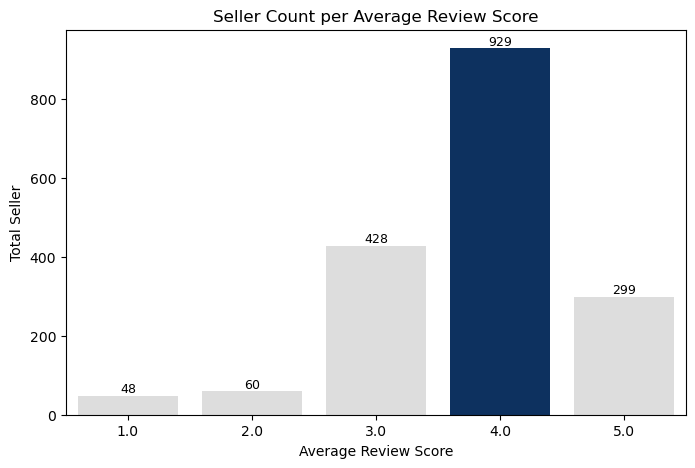

In [47]:
# filter seller hanya dari Sao Paulo & sudah mendapatkan review
sao_paulo = filtered_data[filtered_data.seller_state == 'Sao Paulo']
sao_paulo_review = sao_paulo[~sao_paulo.review_score.isna()]

# menghitung average score review dari setiap seller_id
sao_paulo_review = sao_paulo_review.groupby('seller_id')['review_score'].mean().round(2).reset_index()
sao_paulo_review.rename(columns={'review_score': 'avg_review_score'}, inplace=True)

# menghitung jumlah order dari setiap seller_id
order_count = sao_paulo.groupby('seller_id')['order_id'].count().reset_index().reset_index()
order_count.rename(columns={'order_id': 'order_count'}, inplace=True)

# merge order_count dan seller_review
sao_paulo_review = sao_paulo_review.merge(order_count[['seller_id', 'order_count']], on='seller_id')
sao_paulo_review = sao_paulo_review.sort_values(by='avg_review_score', ascending=True).reset_index()

# menggunakan np.floor untuk mengkategorikan avg review score
sao_paulo_review['floored_review_score'] = np.floor(sao_paulo_review.avg_review_score)

# jumlah seller dengan average review terbanyak
review_score_per_seller = sao_paulo_review.groupby('floored_review_score')['seller_id'].count().reset_index()

# setting data yg paling tinggi akan memiliki warna berbeda
highest = review_score_per_seller.seller_id.max()
colors = ['#002F6C' if val == highest else '#DDDDDD' for val in review_score_per_seller.seller_id]

# visualisasi
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(data = review_score_per_seller,
            x = 'floored_review_score',
            y = 'seller_id',
            ax = ax,
            palette = colors)

# memberikan label ke setiap bar
for container in ax.containers:
    ax.bar_label(container, fontsize=9)

# rename x, y axis and title
ax.set_title('Seller Count per Average Review Score')
ax.set_ylabel('Total Seller')
ax.set_xlabel('Average Review Score')

# menampilkan bar plot
plt.show()

#### 4. Performa seller dalam memproses pesanan

Karena jumlah seller terbanyak berada di state Sao Paulo, maka data akan difilter hanya Seller yang berada di Sao Paulo saja

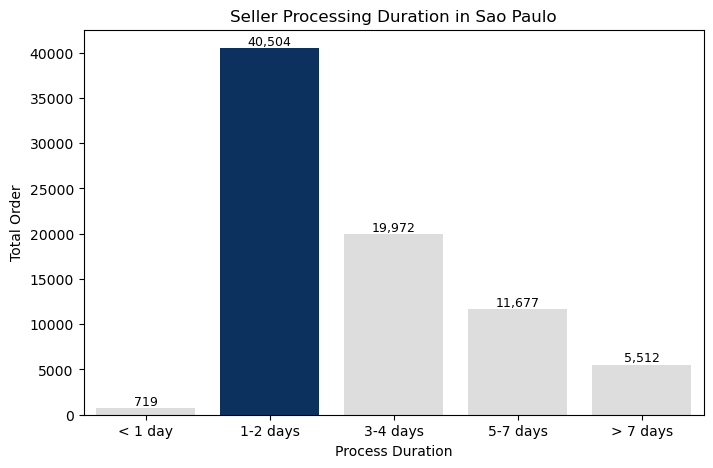

In [45]:
# filtering & aggregating dataframe
seller_process_duration = filtered_data[filtered_data.seller_state == 'Sao Paulo']
seller_process_duration = seller_process_duration.groupby('process_duration')['order_id'].count().reset_index()
seller_process_duration.rename(columns={'order_id': 'order_count_perform'}, inplace=True)

# reorder the label
x_axis_order = ['< 1 day', '1-2 days', '3-4 days', '5-7 days', '> 7 days']
seller_process_duration['process_duration'] = pd.Categorical(seller_process_duration['process_duration'],
                                                             categories=x_axis_order, ordered=True)
seller_process_duration.sort_values(by='process_duration', inplace=True)

# # setting bar color
highest = seller_process_duration.order_count_perform.max()
colors = ['#002F6C' if val == highest else '#DDDDDD' for val in seller_process_duration.order_count_perform]

# visualisasi
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(data = seller_process_duration,
            x = 'process_duration',
            y = 'order_count_perform',
            ax = ax,
            palette = colors)

# memberikan label ke setiap bar
for cont in ax.containers:
    label = [f'{total:,.0f}' for total in cont.datavalues]
    ax.bar_label(cont, label, fontsize=9)

# rename x, y axis and title
ax.set_title('Seller Processing Duration in Sao Paulo')
ax.set_ylabel('Total Order')
ax.set_xlabel('Process Duration')

# menampilkan bar plot
plt.show()